### 3.3.2 - Decision Tree Training

This section goes through the modeling, train, and results of a DecisionTree from Scikit that uses the CART algorithm.

#### CART Decision Tree
The Classification and Regression Trees (CART) algorithm is implemented in [Scikit](https://scikit-learn.org/stable/modules/tree.html) learn as the only Decision Tree algorithm. CART can work with features that are either continuous or categorical. Where as C4.5 and ID3 both require categorical features. C4.5 can handle continuous features, but underneath it creates bins or thresholds -- essentially categories to accommodate.

The CART implementation can work with both binary or multi-class output as well. For features it uses Regression and minimization of mean squared error (MSE) and mean absolute error (MSA).  For Categorical features uses base classification with either **entropy** or **gini** for the impurity measures among the features for each decision tree node.  The germ **gini** is named for the statistician [Corrado Gini](https://en.wikipedia.org/wiki/Corrado_Gini) that devised the measure for gauging economic inequality.

At splitting time, information gain is used based upon the outcome of the Regression or the Classification impurity results for the features.


#### Decision Trees and data scaling
Decision Trees are not sensitive to feature scaling differences. In addition, Decision Trees are non-linear classifiers and have no sensitivity to the linear separability of the data. For the scaling and standardization needs you may decide to scale or normalize the data for visualization needs but the underlying alrorithm relies on value in the Entropy calculations that results in values between `0 and 1`, along with the information gain based upon conditional probabilities that is also positive.


In [1]:

## lets load the data
from utils.helpers import *
df_red, df_white, df_all = pull_and_load_data(force = False)

# create a X_train that is just the features and the associated
# classes (labels) that have been convered to binary classes -- "not good wine", "good wine"
# as described before
X_train, y_train = get_features_and_labels(df_all, binary = True)
print("X_train.shape: {}".format(X_train.shape))
print("y_train.shape: {}".format(y_train.shape))

path exist and not forced
path exist and not forced
X_train.shape: (6497, 11)
y_train.shape: (6497,)


#### 3.3.2.1 - Model Hyperparameter Tuning

As was done in the prior section with SVM, a grid search that will run through the model training. Within Scikit the GridSearchCV can provide a matrix search across all combinations of parameters along with k-fold cross validation of the underlying data. This helps with the manual effort of just run, change parameters, run, that experimentation provides.

For [Decision Tree Classifer](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) the implementation in Scikit provides for several key parameters that affect the training and outcome.

These parameters are:
- criterion
    - this is the measure of the split using either Gini impurity or entropy information gain. Algorithms such as ID3 and C4.5 use entropy primarily but Gini has become and option for updated versions of Decision Tree algorithms based upon C4.5 and even now within the Weka data mining tool.

- max_depth
    - represents the depth of the tree. In decision trees a shallow tree helps to quickly classify new observations, and a deep tree can help to more accuratly classify. However, as the depth increases there is greater chance of overfitting and meaningless results. For this exercise, given the feature count of 21, and from the prior analysis of feature importance, a max depth of 6 or so is probably reasonable.
    
- max_features
    - during GridSearchCV options that can narrow the number of features used these options are:
```
        # max_features from docs:
    #If “auto”, then max_features=sqrt(n_features).
    #If “sqrt”, then max_features=sqrt(n_features).
    #If “log2”, then max_features=log2(n_features).
    #If None, then max_features=n_features.
```

- splitter
    - this switch provides the decision option for at each split how to handle. Best is just that, based upon the Gini impurity or Information gain the tree splits based upon the outcome or value of Gini impurity or Information Gain (entropy based)

**Now, ready to setup and fit...**



In [19]:


import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import tree

parameters = {
    'max_depth' : [2,3,4,5], #range(1,5),
    'criterion' : ['entropy', 'gini'],
    'splitter' : ['best', 'random'],
    'max_features' : ['auto', 'sqrt', 'log2']
}


skf = StratifiedKFold(n_splits = 10,
                      random_state = 42, 
                      shuffle = True)

grid = GridSearchCV(
    tree.DecisionTreeClassifier(),
    parameters,
    return_train_score = True,
    cv = skf)
    

grid.fit(X = X_train , y = y_train)

print('done training')



done training



#### 3.3.2.2 - Grid Result

Now lets take a look at the `best score`, `best parameters` as these will be what is used in the direct scoring run further down.


In [20]:

print("score = %3.4f" %(grid.best_score_))
print(grid.best_params_)

score = 0.7269
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'splitter': 'best'}



We can see that the grid search best score is above, along with the best parameters that achieved that score.

#### 3.3.2.3 - Best Estimator

Interesting enough, we can retrieve the instance of the estimator (instance of the DecisionTreeClassifer class) and run the model for scoring against the dataset.

Lets emit a few values that come back from the grid search.


In [21]:

print('Best estimator score: {:.4f}'.format(grid.best_estimator_.score(X_train, y_train)))
print('Grid Score: {:.4f}'.format(grid.score(X_train, y_train)))
print('Grid Best Score: {:.4f}'.format(grid.best_score_))


Best estimator score: 0.7487
Grid Score: 0.7487
Grid Best Score: 0.7269



#### 3.3.2.4 - Explanation of differences

After this step, the Grid Best score is what we will work with. However, to explain why the differences in the scoring above you have to understand what the `best_estimator` is.

The `best_estimator+_` attached to the grid object is an instance of the solver, in this case DecisionTree, that achieve the highest score **for a specific fold** - and not the entire cross validation iterations.  That same solver is also used when calling the grid's `score` function. It does not represent the best score and solver that had the best score when run against all 10 folds.

The grid's `best_score_` attribute is that value.


#### 3.3.2.5 - Rerunning the Training

At this point we take a track that indicates we have optimized parameters:
```
score = 0.7269
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'splitter': 'best'}
```

Now apply a different function from Scikit that runs the same cross validation, but using one set of parameters.

This approach is still a great time saver as it eliminates the need to manually segment the data, ensure it is stratified, and collect the results.

Now plug those into the DecisionTreeClassifer instance along with the same settings for the StratifedKFold processor.




In [22]:
best_parms = grid.best_params_
best_parms

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'splitter': 'best'}

In [23]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

clf = tree.DecisionTreeClassifier(
    max_depth = best_parms['max_depth'],
    max_features = best_parms['max_features'],
    splitter = best_parms['splitter'],
    criterion = best_parms['criterion'])


skf = StratifiedKFold(n_splits = 10,
                      random_state = 42, 
                      shuffle = True)

scores = cross_val_score(
    estimator = clf,
    X = X_train,
    y = y_train,
    cv = skf)

#The mean score and the 95% confidence interval of the score estimate are hence given by:
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

Accuracy: 0.7266 (+/- 0.04)


array([0.71384615, 0.70615385, 0.70307692, 0.73538462, 0.72461538,
       0.75230769, 0.71538462, 0.73651772, 0.71340524, 0.76579353])



##### 3.3.2.6 - ROC and AUC

There's plenty of observations that it is possible to generate the Receiver Operating Characteristics (ROC) curve and the Area Under the Curve (AUC).

With Skikit learn it takes use of the same `cross_validation` set of helper functions just supplying what `method` to be used.

In this case, the `DecisionTreeClassifer` class has a `predict_proba` that can provide the probabilities needed for each of the data points. Normally, a call to `cross_val_predict` would call the `predict` on the classifer, which just provides the class prediction based upon the input features.

But here, we are using it to generate our ROC data.


#### 3.3.2.7 - Prediction and ROC calculations

In [24]:

skf = StratifiedKFold(n_splits = 10,
                      random_state = 42, 
                      shuffle = True)

clf = tree.DecisionTreeClassifier(
    max_depth = best_parms['max_depth'],
    max_features = best_parms['max_features'],
    splitter = best_parms['splitter'],
    criterion = best_parms['criterion'])

    
y_pred = cross_val_predict(
    clf,
    X_train,
    y_train,
    cv = skf,
    method = 'predict_proba',
    verbose = 0)

# need to reshape as the 2nd column is just the 1 - P 
y_pred = y_pred[:, 1]

r_auc, tp, fp = show_auc(y_train, y_pred )


Auc:[0] = 0.76638 and Auc:[1] = 0.76638 - which MUST be the same given we have a binary classification


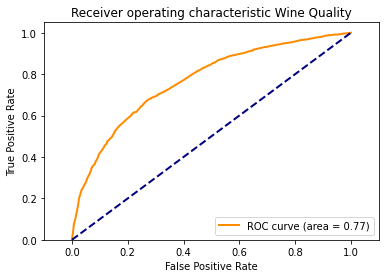

In [25]:
#now plot ROC.

plot_roc(r_auc, tp, fp)



#### 3.3.2.9 - Tree Visual

Next a plot of the Best Estimator from the Grid search is used, and we can see that Alcohol content is shown as the root node. This is consistent with the EDA done showing Alcohol as the most influential by correlation against the quality of each observation.



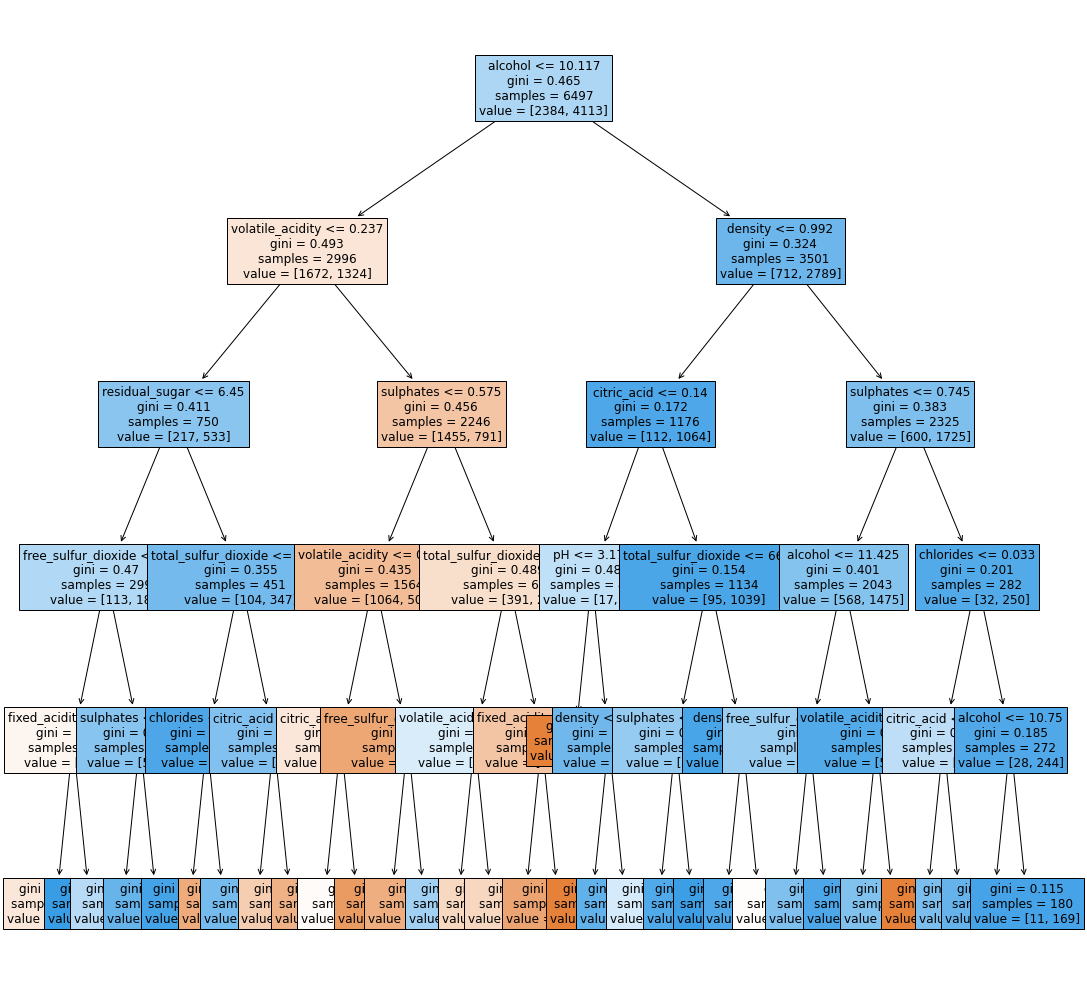

In [26]:

figsize = 18, 18
plt.figure(figsize = figsize)
feature_names = ["fixed_acidity", "volatile_acidity", "citric_acid", \
                     "residual_sugar", "chlorides", "free_sulfur_dioxide", \
                     "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"]

tree.plot_tree(
    grid.best_estimator_, 
    filled=True, 
    fontsize=12,
    feature_names=feature_names)
plt.show()



##### 3.3.2.9.1 - Refit 

Finally, running another fit using the best parameters against the full training data set to see what kinde of final result we can obtain for accuracy score and tree.

In addition, to make the diagram readable, the depth will be narrowed. Note this results in a different fitted model compared to the "best estimator" from the Grid Search - which as described before is not the estimator that would be used for production predictions.




In [30]:


clf = tree.DecisionTreeClassifier(
    max_depth=5,
    criterion='gini',
    splitter='best',
    max_features=5)


clf = clf.fit(X = X_train, y = y_train)
print('done training')




done training


In [31]:
## print out the score, against the training data ..
clf.score(X_train, y_train)

0.7520394028012929


##### 3.3.2.9.2 - Refit result

Note we now have a model using the best parameters obtained from grid search and cross validation, but retrained against the full dataset. When we visualize this while Alcohol remains at the root, there are some changes on the weights causing some shifting of results. 



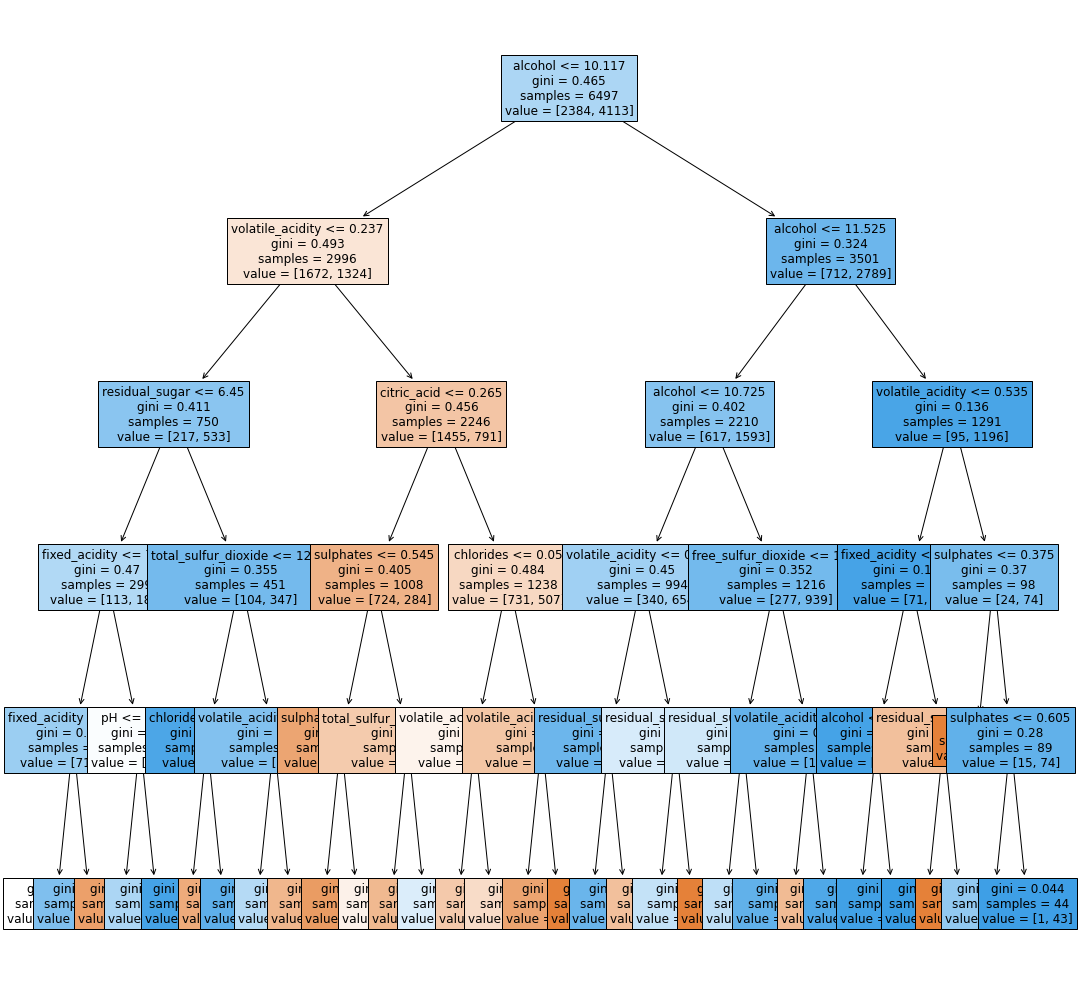

In [32]:

figsize = 18, 18
plt.figure(figsize = figsize)

tree.plot_tree(
    clf, 
    filled=True, 
    fontsize=12,
    feature_names=feature_names)

plt.show()